In [1]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, 24, 10, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=True)
# features = getFeatures()

In [3]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 13])
torch.Size([64, 10])


In [4]:
class LSTM_LSTM(nn.Module):
    def __init__(self, hist_input_size, covariates_size, input_len, output_len, lstm_num_hidden, num_layers=1):
        super(LSTM_LSTM, self).__init__()
        self.encoder = nn.LSTM(hist_input_size, lstm_num_hidden, num_layers, batch_first=True)
        self.decoder = nn.LSTM(covariates_size, lstm_num_hidden, num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_num_hidden, 1)
        self.input_len = input_len
        self.output_len = output_len

    def forward(self, x_encoder, x_decoder):
        # x: (batch_size, input_len, input_size)
        _, (h, c) = self.encoder(x_encoder)
        outputs = []
        for t in range(self.output_len):
            xt = x_decoder[:, t, :].unsqueeze(1)
            output, (h, c) = self.decoder(xt, (h, c))
            output = self.fc(output)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

hist_input_size = len(select_features)
covariate_size = 6
input_len = 20
output_len = 10
hidden_size = 32
num_layers = 1

# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = LSTM_LSTM(hist_input_size, covariate_size, 
                    input_len, output_len, hidden_size, num_layers=num_layers).to(device)

cuda
7


In [25]:
data.head()

flight  time  wind_speed  wind_angle  battery_voltage  \
flight                                                            
1      0       1   0.0    0.005525    0.033426        24.222174   
       1       1   0.2    0.005525    0.008357        24.227180   
       2       1   0.3    0.005525    0.980501        24.225929   
       3       1   0.5    0.005525    0.986072        24.224678   
       4       1   0.6    0.005525    1.000000        24.210905   

          battery_current  position_x  position_y  position_z  orientation_x  \
flight                                                                         
1      0         0.087470  -79.782396   40.458047  269.332402       0.001772   
       1         0.095421  -79.782396   40.458047  269.332056       0.001768   
       2         0.095421  -79.782396   40.458047  269.333081       0.001768   
       3         0.095421  -79.782396   40.458047  269.334648       0.001775   
       4         0.079518  -79.782396   40.458047  269.336178       0.001775   

          ...  current_atm  energy_atm  current_consumed  energy_consumed  \
flight    ...                                                               
1      0  ...     0.000000    0.000000          0.000000         0.000000   
       1  ...     0.019084    0.462358          0.019084         0.462358   
       2  ...     0.009542    0.231167          0.028626         0.693525   
       3  ...     0.019084    0.462310          0.047711         1.155835   
       4  ...     0.007952    0.192520          0.055662         1.348354   

          x_future  y_future  z_future  x_change  y_change  z_change  
flight                                                                
1      0  0.993124  0.899653  0.203843  0.319572  0.455911  0.643663  
       1  0.993124  0.899653  0.203858  0.319057  0.455911  0.643691  
       2  0.993124  0.899653  0.203871  0.319486  0.455911  0.643679  
       3  0.993124  0.899653  0.203889  0.318971  0.455911  0.643738  
       4  0.993123  0.899653  0.203894  0.319143  0.455911  0.643574  

[5 rows x 40 columns]

In [15]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 20
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        hist_inputs = inputs[:, :, :hist_input_size].to(device)
        covariates = inputs[:, :output_len, hist_input_size:].to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(hist_inputs, covariates)
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        
        hist_inputs = inputs[:, :, :hist_input_size].to(device)
        covariates = inputs[:, :output_len, hist_input_size:].to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = seq2seq(hist_inputs, covariates)
            outputs = outputs.squeeze(-1) # (batch_size, output_len)
            loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'LSTM_LSTM_select_covariates_best_model_{input_len}-{output_len}.pt')


Epoch 1/20 [TRAIN]: 100%|██████████| 2243/2243 [00:25<00:00, 87.77it/s, train_loss=0.00257]


Epoch 1/20, Average Training Loss: 0.003403


Epoch 1/20 [VAL]: 100%|██████████| 751/751 [00:03<00:00, 202.27it/s, val_loss=0.00349]


Epoch 1/20, Average Validation Loss: 0.003327


Epoch 2/20 [TRAIN]: 100%|██████████| 2243/2243 [00:26<00:00, 85.73it/s, train_loss=0.00187]


Epoch 2/20, Average Training Loss: 0.003300


Epoch 2/20 [VAL]: 100%|██████████| 751/751 [00:03<00:00, 203.64it/s, val_loss=0.00339]


Epoch 2/20, Average Validation Loss: 0.003037


Epoch 3/20 [TRAIN]: 100%|██████████| 2243/2243 [00:23<00:00, 94.33it/s, train_loss=0.0047] 


Epoch 3/20, Average Training Loss: 0.003132


Epoch 3/20 [VAL]: 100%|██████████| 751/751 [00:03<00:00, 201.95it/s, val_loss=0.0038] 


Epoch 3/20, Average Validation Loss: 0.003381


Epoch 4/20 [TRAIN]: 100%|██████████| 2243/2243 [00:24<00:00, 92.69it/s, train_loss=0.00196]


Epoch 4/20, Average Training Loss: 0.003077


Epoch 4/20 [VAL]: 100%|██████████| 751/751 [00:03<00:00, 198.79it/s, val_loss=0.00356]


Epoch 4/20, Average Validation Loss: 0.003009


Epoch 5/20 [TRAIN]: 100%|██████████| 2243/2243 [00:25<00:00, 89.04it/s, train_loss=0.00338]


Epoch 5/20, Average Training Loss: 0.003017


Epoch 5/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 181.93it/s, val_loss=0.0033] 


Epoch 5/20, Average Validation Loss: 0.002954


Epoch 6/20 [TRAIN]: 100%|██████████| 2243/2243 [00:28<00:00, 77.56it/s, train_loss=0.0029] 


Epoch 6/20, Average Training Loss: 0.002965


Epoch 6/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 172.72it/s, val_loss=0.0035] 


Epoch 6/20, Average Validation Loss: 0.003070


Epoch 7/20 [TRAIN]: 100%|██████████| 2243/2243 [00:29<00:00, 76.02it/s, train_loss=0.00291]


Epoch 7/20, Average Training Loss: 0.002996


Epoch 7/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 173.72it/s, val_loss=0.00353]


Epoch 7/20, Average Validation Loss: 0.003072


Epoch 8/20 [TRAIN]: 100%|██████████| 2243/2243 [00:28<00:00, 77.73it/s, train_loss=0.00136]


Epoch 8/20, Average Training Loss: 0.002854


Epoch 8/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 159.48it/s, val_loss=0.00323]


Epoch 8/20, Average Validation Loss: 0.002949


Epoch 9/20 [TRAIN]: 100%|██████████| 2243/2243 [00:27<00:00, 80.41it/s, train_loss=0.00199]


Epoch 9/20, Average Training Loss: 0.002837


Epoch 9/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 182.11it/s, val_loss=0.00346]


Epoch 9/20, Average Validation Loss: 0.002901


Epoch 10/20 [TRAIN]: 100%|██████████| 2243/2243 [00:26<00:00, 85.95it/s, train_loss=0.00228]


Epoch 10/20, Average Training Loss: 0.002816


Epoch 10/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 181.23it/s, val_loss=0.00346]


Epoch 10/20, Average Validation Loss: 0.002820


Epoch 11/20 [TRAIN]: 100%|██████████| 2243/2243 [00:28<00:00, 78.91it/s, train_loss=0.00303]


Epoch 11/20, Average Training Loss: 0.002732


Epoch 11/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 168.50it/s, val_loss=0.00319]


Epoch 11/20, Average Validation Loss: 0.002743


Epoch 12/20 [TRAIN]: 100%|██████████| 2243/2243 [00:31<00:00, 71.29it/s, train_loss=0.00308]


Epoch 12/20, Average Training Loss: 0.002708


Epoch 12/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 168.95it/s, val_loss=0.00301]


Epoch 12/20, Average Validation Loss: 0.002723


Epoch 13/20 [TRAIN]: 100%|██████████| 2243/2243 [00:30<00:00, 72.75it/s, train_loss=0.00178]


Epoch 13/20, Average Training Loss: 0.002675


Epoch 13/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 171.50it/s, val_loss=0.00302]


Epoch 13/20, Average Validation Loss: 0.002755


Epoch 14/20 [TRAIN]: 100%|██████████| 2243/2243 [00:28<00:00, 77.52it/s, train_loss=0.00234]


Epoch 14/20, Average Training Loss: 0.002649


Epoch 14/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 166.46it/s, val_loss=0.003]  


Epoch 14/20, Average Validation Loss: 0.002679


Epoch 15/20 [TRAIN]: 100%|██████████| 2243/2243 [00:30<00:00, 74.30it/s, train_loss=0.00219]


Epoch 15/20, Average Training Loss: 0.002648


Epoch 15/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 174.77it/s, val_loss=0.00299]


Epoch 15/20, Average Validation Loss: 0.002660


Epoch 16/20 [TRAIN]: 100%|██████████| 2243/2243 [00:28<00:00, 77.44it/s, train_loss=0.00277]


Epoch 16/20, Average Training Loss: 0.002592


Epoch 16/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 169.79it/s, val_loss=0.00288]


Epoch 16/20, Average Validation Loss: 0.002645


Epoch 17/20 [TRAIN]: 100%|██████████| 2243/2243 [00:29<00:00, 76.55it/s, train_loss=0.00261]


Epoch 17/20, Average Training Loss: 0.002592


Epoch 17/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 176.00it/s, val_loss=0.00292]


Epoch 17/20, Average Validation Loss: 0.002678


Epoch 18/20 [TRAIN]: 100%|██████████| 2243/2243 [00:28<00:00, 77.95it/s, train_loss=0.00301]


Epoch 18/20, Average Training Loss: 0.002552


Epoch 18/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 176.83it/s, val_loss=0.00292]


Epoch 18/20, Average Validation Loss: 0.002699


Epoch 19/20 [TRAIN]: 100%|██████████| 2243/2243 [00:28<00:00, 79.76it/s, train_loss=0.0016] 


Epoch 19/20, Average Training Loss: 0.002540


Epoch 19/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 181.14it/s, val_loss=0.00308]


Epoch 19/20, Average Validation Loss: 0.002672


Epoch 20/20 [TRAIN]: 100%|██████████| 2243/2243 [00:27<00:00, 82.83it/s, train_loss=0.00305]


Epoch 20/20, Average Training Loss: 0.002510


Epoch 20/20 [VAL]: 100%|██████████| 751/751 [00:04<00:00, 181.23it/s, val_loss=0.00292]

Epoch 20/20, Average Validation Loss: 0.002626


In [20]:
features = getFeatures(covariates=True)
features[-6:]

['x_future', 'y_future', 'z_future', 'x_change', 'y_change', 'z_change']

Test loss: 0.0023675060365349054
torch.Size([1412, 10])
torch.Size([1412, 10])
tensor([15.1720, 15.3821, 13.9269, 13.8731, 14.2865, 14.4783, 14.0160, 13.8090,
        14.5845, 15.6976], device='cuda:0')
MAPE: 14.522579193115234


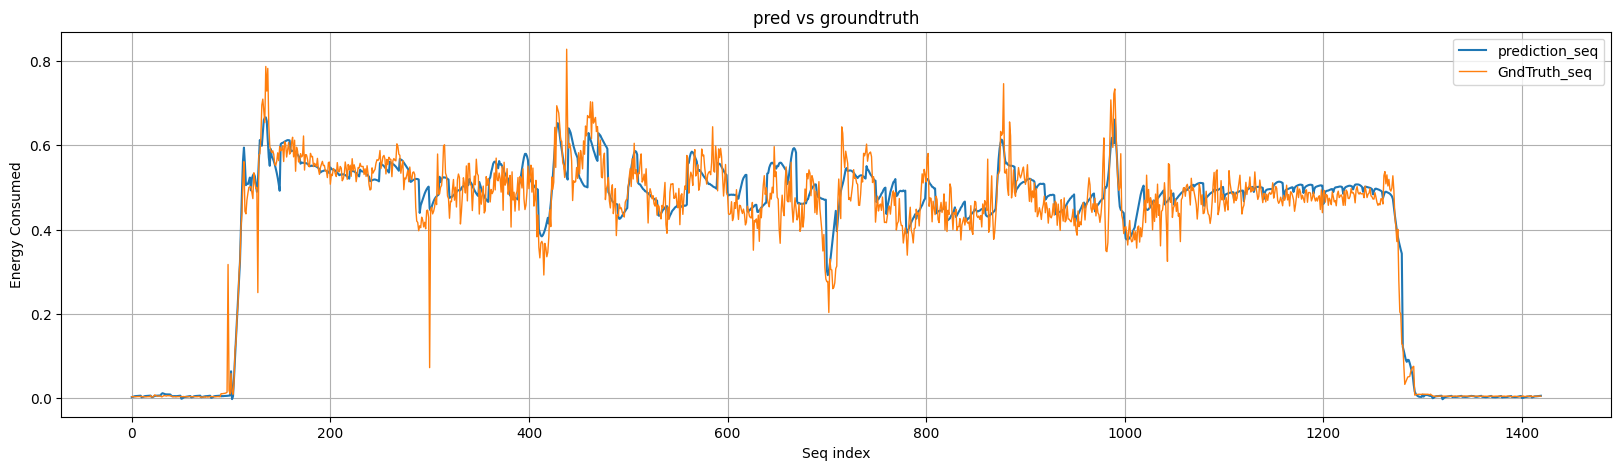

In [42]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'LSTM_LSTM_select_covariates_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 270 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features + features[-6:]].values, 
                                         test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    hist_inputs = input_seq[:, :, :hist_input_size].to(device)
    covariates = input_seq[:, :output_len, hist_input_size:].to(device)
    targets = targets.to(device)
    outputs = seq2seq(hist_inputs, covariates)

    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(torch.mean(torch.abs((outputs - targets) / targets)*100,  axis=0))
    print(f"MAPE: {mape}")

    # print(outputs.shape)
    # print(targets.shape)
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [45]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    hist_inputs = inputs[:, :, :hist_input_size].to(device)
    covariates = inputs[:, :output_len, hist_input_size:].to(device)
    targets = targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(hist_inputs, covariates)
        outputs = outputs.squeeze(-1) # (batch_size, output_len)
        loss = criterion(outputs, targets)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 15.818809693568461


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""